# MNIST Dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/sorix/blob/qa/docs/examples/nn/4-digit-recognizer.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Mitchell-Mirano/sorix/blob/qa/docs/examples/nn/4-digit-recognizer.ipynb)
[![Open in Docs](https://img.shields.io/badge/Open%20in-Docs-blue?logo=readthedocs)](http://127.0.0.1:8000/examples/nn/4-digit-recognizer)

In [1]:
# Uncomment the following line to install GPU version with Cupy backend
#!pip install 'sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@qa'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sorix
from sorix import tensor
from sorix.nn import Module,Linear, CrossEntropyLoss,ReLU,BatchNorm1d,Dropout
from sorix.optim import SGDMomentum, RMSprop, Adam
from sorix.model_selection import train_test_split
from sorix.utils.data import Dataset, DataLoader
from sorix.metrics import confusion_matrix,classification_report
from datetime import datetime

In [3]:
device = 'cuda' if sorix.cuda.is_available() else "cpu"
device

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 14.0.1


'cuda'

In [4]:
data = pd.read_csv("../data/digit-recognizer/train.csv")

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_train,data_test = train_test_split(data,test_size=0.2)

In [7]:
X_train = data_train.drop("label",axis=1).values
Y_train = data_train[["label"]].values

X_test = data_test.drop("label",axis=1).values
Y_test = data_test[["label"]].values

train_dataset = Dataset(X_train,Y_train)    
test_dataset = Dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=64)
test_dataloader = DataLoader(test_dataset,batch_size=64)

In [8]:
for x,y in train_dataloader:
    print(x.shape,y.shape)
    break

(64, 784) (64, 1)


In [9]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(784,128,bias=False)
        self.bn1 = BatchNorm1d(128)
        self.linear2 = Linear(128,64)
        self.linear3 = Linear(64,10)
        self.relu = ReLU()
        self.dropout = Dropout(p=0.2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x
    

model = Model()
model.to(device)
loss_fn = CrossEntropyLoss()

optimizer = RMSprop(model.parameters(), lr=1e-3)


In [10]:
for X,Y in train_dataloader:
    X_tensor = tensor(X, device=device)
    Y_tensor = tensor(Y, device=device)
    print(X_tensor.shape,Y_tensor.shape)
    break

sorix.Size([64, 784]) sorix.Size([64, 1])


In [11]:
start = datetime.now()

epochs = 100

for epoch in range(epochs+1):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in train_dataloader:
        x = tensor(x, device=device)
        y = tensor(y, device=device)

        # Forward
        logits = model(x)
        loss = loss_fn(logits, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular loss y accuracy
        total_train_loss += loss.data.get() * len(y)  # ponderar por tamaño del batch
        preds = sorix.argmax(logits,axis=1,keepdims=True)
        correct_train += (preds == y).sum().item()
        total_train += len(y)

    avg_train_loss = total_train_loss / total_train
    avg_train_acc = correct_train / total_train

    # --- Validación/Test ---
    if epoch % 5 == 0:
        with sorix.no_grad():
            model.eval()
            total_test_loss = 0.0
            correct_test = 0
            total_test = 0

            for x, y in test_dataloader:
                x = tensor(x, device=device)
                y = tensor(y, device=device)

                logits = model(x)
                loss = loss_fn(logits,y)

                total_test_loss += loss.data.get() * len(y)
                preds = sorix.argmax(logits,axis=1,keepdims=True)
                correct_test += (preds == y).sum().item()
                total_test += len(y)

            avg_test_loss = total_test_loss / total_test
            avg_test_acc = correct_test / total_test
            
            print(f"[{device}] [{epoch:3d}/{epochs:3d}] | Loss: {avg_test_loss:.4f} | Acc Train: {100*avg_train_acc:.2f}% | Acc Test: {100*avg_test_acc:.2f}%")

        if avg_test_acc > 0.97:
            break
end = datetime.now()

delta = end-start
tiempo = delta.total_seconds()
print(f"Tiempo:{tiempo} segundos = {tiempo/60:.2f} min ")

[cuda] [  0/100] | Loss: 0.2020 | Acc Train: 86.62% | Acc Test: 94.24%


[cuda] [  5/100] | Loss: 0.1093 | Acc Train: 96.48% | Acc Test: 96.77%


[cuda] [ 10/100] | Loss: 0.1133 | Acc Train: 97.61% | Acc Test: 97.14%
Tiempo:20.778458 segundos = 0.35 min 


In [12]:
all_preds = np.array([])
all_targets = np.array([])

with sorix.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x = tensor(x, device=device)
        y = tensor(y, device=device)
        # Predicciones
        logits = model(x)
        preds = sorix.argmax(logits,axis=1,keepdims=True).cpu()
        # Guardar predicciones y targets
        all_preds = np.append(all_preds,preds)
        all_targets = np.append(all_targets,y.cpu())


In [13]:
print(classification_report(all_targets,all_preds))

            precision   recall f1-score  support
0.0              0.98     0.98     0.98      798
1.0              0.98     0.99     0.98      920
2.0              0.98     0.96     0.97      797
3.0              0.97     0.96     0.97      858
4.0              0.97     0.97     0.97      813
5.0              0.96     0.99     0.97      772
6.0              0.98     0.98     0.98      849
7.0              0.98     0.96     0.97      929
8.0              0.95     0.97     0.96      810
9.0              0.96     0.95     0.96      854

accuracy                           0.97     8400
macro avg        0.97     0.97     0.97     8400
weighted avg     0.97     0.97     0.97     8400


<Axes: >

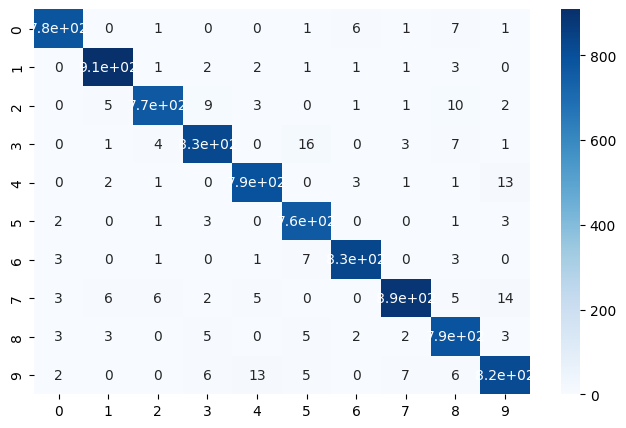

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(all_targets,all_preds), annot=True, cmap="Blues")